In [84]:
# Import libraries and modules
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, ConcatDataset
from torchvision.transforms import Compose 
from torch.nn import Linear, Conv2d, MaxPool2d, AvgPool2d
from torch.nn import ReLU, Softmax, BatchNorm2d, Dropout, Flatten

import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [85]:
# Define data augmentation
train_transform = Compose([
        transforms.GaussianBlur(kernel_size=15, sigma=(0.1,0.5)),
        transforms.ColorJitter(brightness=0.3, saturation=0.3, hue=0.2), 
        transforms.RandomAffine(degrees=15, scale=(0.9,1.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=0.131, std=0.3085)
    ])

test_transform = Compose([
    transforms.ToTensor()
])

# Load MNIST training and testing Dataset objects
train_dataset = datasets.MNIST('./data', train=True, download=True,  # Downloads into a directory ../data
                               transform=train_transform)
train_dataset_untransformed = datasets.MNIST('./data', train=True, download=True,  # Downloads into a directory ../data
                               transform=test_transform)
test_dataset = datasets.MNIST('./data', train=False, download=False,  # No need to download again
                              transform=test_transform)

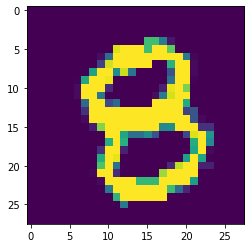

In [78]:
# Visualize data augmentation
import random
plt.imshow(train_dataset[random.randint(0, len(train_dataset))][0][0].numpy())

In [65]:
# Define training variables
batch_size = 32
test_batch_size = 32
epochs = 10
lr=1.0
step=1
gamma=0.7
log_interval=10

In [86]:
# You can assign indices for training/validation or use a random subset for
# training by using SubsetRandomSampler. Right now the train and validation
# sets are built from the same indices - this is bad! Change it so that
# the training and validation sets are disjoint and have the correct relative sizes.
#subset_indices_train = range(len(train_dataset))
#subset_indices_valid = range(len(train_dataset))

# Create a validation set by sampling 15% of each digit class from training dataset
subset_indices_train = []
subset_indices_valid = []
labels = [train_dataset[row][1] for row in range(len(train_dataset))]
for digit in range(0, 10):
    indices = list(filter(lambda x: labels[x] == digit, range(len(labels))))
    # randomly sample 15% for validation, rest for train
    random.shuffle(indices)
    split = int(0.15*len(indices))
    subset_indices_valid.extend(indices[:split])
    subset_indices_train.extend(indices[split:])

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size,
    sampler=SubsetRandomSampler(subset_indices_train)
)
val_loader = torch.utils.data.DataLoader(
    train_dataset_untransformed, batch_size=test_batch_size,
    sampler=SubsetRandomSampler(subset_indices_valid)
)

In [87]:
# Define Model using only...
# Linear, Conv2d, MaxPool2d, AvgPool2d, ReLU, Softmax, BatchNorm2d, Dropout, Flatten
class fcNet(nn.Module):
    '''
    Design your model with fully connected layers (convolutional layers are not
    allowed here). Initial model is designed to have a poor performance. These
    are the sample units you can try:
        Linear, Dropout, activation layers (ReLU, softmax)
    '''
    def __init__(self):
        # Define the units that you will use in your model
        # Note that this has nothing to do with the order in which operations
        # are applied - that is defined in the forward function below.
        super(fcNet, self).__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=20)
        self.fc2 = nn.Linear(20, 10)
        self.dropout1 = nn.Dropout(p=0.5)

    def forward(self, x):
        # Define the sequence of operations your model will apply to an input x
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = F.relu(x)

        output = F.log_softmax(x, dim=1)
        return output


class ConvNet(nn.Module):
    '''
    Design your model with convolutional layers.
    '''
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3,3), stride=1)
        self.conv2 = nn.Conv2d(8, 8, 3, 1)
        self.dropout1 = nn.Dropout2d(0.5)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(200, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout2(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        output = F.log_softmax(x, dim=1)
        return output


class Net(nn.Module):
    '''
    Build the best MNIST classifier.
    '''
    def __init__(self):
        super(Net, self).__init__()

    def forward(self, x):
        return x


In [88]:
# Define training and testing
def train(model, device, train_loader, optimizer, epoch):
    '''
    This is your training function. When you call this function, the model is
    trained for 1 epoch.
    '''
    model.train()   # Set the model to training mode
    total = 0
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()               # Clear the gradient
        output = model(data)                # Make predictions
        loss = F.nll_loss(output, target)   # Compute loss
        train_loss += F.nll_loss(output, target, reduction='sum').item()
        loss.backward()                     # Gradient computation
        optimizer.step()                    # Perform a single optimization step
        # Compute accuracy
        pred = output.argmax(dim=1, keepdim=True) # Predictions with max log-probability
        total += len(data)
        correct += pred.eq(target.view_as(pred)).sum().item()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.sampler),
                100. * batch_idx / len(train_loader), loss.item(),
                100. * correct / total))
    train_loss /= total
    accuracy = 100. * correct / total
    print("Train Set Accuracy: ", accuracy)
    return accuracy, loss

def test(model, device, test_loader):
    model.eval()    # Set the model to inference mode
    test_loss = 0
    correct = 0
    test_num = 0
    with torch.no_grad():   # For the inference step, gradient is not computed
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            test_num += len(data)

    test_loss /= test_num
    accuracy = 100. * correct / test_num
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, test_num, accuracy))
    
    return accuracy, test_loss

In [89]:
# Load your model [fcNet, ConvNet, Net]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvNet().to(device)

# Try different optimzers here [Adam, SGD, RMSprop]
optimizer = optim.Adadelta(model.parameters(), lr=lr)

# Set your learning rate scheduler
scheduler = StepLR(optimizer, step_size=step, gamma=gamma)

# Training loop
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
for epoch in range(1, epochs + 1):
    acc, loss = train(model, device, train_loader, optimizer, epoch)
    train_acc.append(acc)
    train_loss.append(loss)
    acc, loss = test(model, device, val_loader)
    valid_acc.append(acc)
    valid_loss.append(loss)
    scheduler.step()    # learning rate scheduler

    # You may optionally save your model at each epoch here


Train Epoch: 1 [0/51005 (0%)]	Loss: 2.302656	Accuracy: 6.250000
Train Epoch: 1 [320/51005 (1%)]	Loss: 2.208545	Accuracy: 11.363636
Train Epoch: 1 [640/51005 (1%)]	Loss: 2.004967	Accuracy: 16.517857
Train Epoch: 1 [960/51005 (2%)]	Loss: 1.796008	Accuracy: 22.076613
Train Epoch: 1 [1280/51005 (3%)]	Loss: 1.508423	Accuracy: 28.810976
Train Epoch: 1 [1600/51005 (3%)]	Loss: 1.588852	Accuracy: 32.169118
Train Epoch: 1 [1920/51005 (4%)]	Loss: 1.524452	Accuracy: 36.577869
Train Epoch: 1 [2240/51005 (4%)]	Loss: 1.233652	Accuracy: 39.524648
Train Epoch: 1 [2560/51005 (5%)]	Loss: 1.098319	Accuracy: 42.862654
Train Epoch: 1 [2880/51005 (6%)]	Loss: 0.859685	Accuracy: 45.364011
Train Epoch: 1 [3200/51005 (6%)]	Loss: 0.637540	Accuracy: 47.617574
Train Epoch: 1 [3520/51005 (7%)]	Loss: 0.748411	Accuracy: 49.887387
Train Epoch: 1 [3840/51005 (8%)]	Loss: 0.608467	Accuracy: 51.652893
Train Epoch: 1 [4160/51005 (8%)]	Loss: 0.297775	Accuracy: 53.697519
Train Epoch: 1 [4480/51005 (9%)]	Loss: 0.888354	Accurac

Train Epoch: 1 [37760/51005 (74%)]	Loss: 0.369710	Accuracy: 80.593776
Train Epoch: 1 [38080/51005 (75%)]	Loss: 0.319514	Accuracy: 80.670130
Train Epoch: 1 [38400/51005 (75%)]	Loss: 0.387739	Accuracy: 80.711386
Train Epoch: 1 [38720/51005 (76%)]	Loss: 0.272743	Accuracy: 80.759703
Train Epoch: 1 [39040/51005 (77%)]	Loss: 0.607222	Accuracy: 80.799550
Train Epoch: 1 [39360/51005 (77%)]	Loss: 0.970375	Accuracy: 80.856519
Train Epoch: 1 [39680/51005 (78%)]	Loss: 0.232138	Accuracy: 80.889907
Train Epoch: 1 [40000/51005 (78%)]	Loss: 0.139950	Accuracy: 80.955236
Train Epoch: 1 [40320/51005 (79%)]	Loss: 0.358488	Accuracy: 81.002181
Train Epoch: 1 [40640/51005 (80%)]	Loss: 0.248761	Accuracy: 81.045928
Train Epoch: 1 [40960/51005 (80%)]	Loss: 0.181857	Accuracy: 81.067037
Train Epoch: 1 [41280/51005 (81%)]	Loss: 0.847923	Accuracy: 81.131390
Train Epoch: 1 [41600/51005 (82%)]	Loss: 0.442490	Accuracy: 81.168332
Train Epoch: 1 [41920/51005 (82%)]	Loss: 0.257175	Accuracy: 81.211861
Train Epoch: 1 [4224

Train Epoch: 2 [24000/51005 (47%)]	Loss: 0.155281	Accuracy: 88.902297
Train Epoch: 2 [24320/51005 (48%)]	Loss: 0.166351	Accuracy: 88.916721
Train Epoch: 2 [24640/51005 (48%)]	Loss: 0.569485	Accuracy: 88.898346
Train Epoch: 2 [24960/51005 (49%)]	Loss: 0.203380	Accuracy: 88.872439
Train Epoch: 2 [25280/51005 (50%)]	Loss: 0.119591	Accuracy: 88.902497
Train Epoch: 2 [25600/51005 (50%)]	Loss: 0.432367	Accuracy: 88.920100
Train Epoch: 2 [25920/51005 (51%)]	Loss: 0.213514	Accuracy: 88.929562
Train Epoch: 2 [26240/51005 (51%)]	Loss: 0.655565	Accuracy: 88.908343
Train Epoch: 2 [26560/51005 (52%)]	Loss: 0.725767	Accuracy: 88.902677
Train Epoch: 2 [26880/51005 (53%)]	Loss: 0.340860	Accuracy: 88.960315
Train Epoch: 2 [27200/51005 (53%)]	Loss: 0.146150	Accuracy: 88.976204
Train Epoch: 2 [27520/51005 (54%)]	Loss: 0.258843	Accuracy: 88.955430
Train Epoch: 2 [27840/51005 (55%)]	Loss: 0.329440	Accuracy: 88.960247
Train Epoch: 2 [28160/51005 (55%)]	Loss: 0.263028	Accuracy: 88.989784
Train Epoch: 2 [2848

Train Epoch: 3 [10240/51005 (20%)]	Loss: 0.542018	Accuracy: 90.381620
Train Epoch: 3 [10560/51005 (21%)]	Loss: 0.755186	Accuracy: 90.388973
Train Epoch: 3 [10880/51005 (21%)]	Loss: 0.632280	Accuracy: 90.377566
Train Epoch: 3 [11200/51005 (22%)]	Loss: 0.192753	Accuracy: 90.384615
Train Epoch: 3 [11520/51005 (23%)]	Loss: 0.156923	Accuracy: 90.408587
Train Epoch: 3 [11840/51005 (23%)]	Loss: 0.105353	Accuracy: 90.448113
Train Epoch: 3 [12160/51005 (24%)]	Loss: 0.257806	Accuracy: 90.436352
Train Epoch: 3 [12480/51005 (24%)]	Loss: 0.329018	Accuracy: 90.441176
Train Epoch: 3 [12800/51005 (25%)]	Loss: 0.268007	Accuracy: 90.476933
Train Epoch: 3 [13120/51005 (26%)]	Loss: 0.158509	Accuracy: 90.526156
Train Epoch: 3 [13440/51005 (26%)]	Loss: 0.259069	Accuracy: 90.513658
Train Epoch: 3 [13760/51005 (27%)]	Loss: 0.539918	Accuracy: 90.501740
Train Epoch: 3 [14080/51005 (28%)]	Loss: 0.184058	Accuracy: 90.547052
Train Epoch: 3 [14400/51005 (28%)]	Loss: 0.175504	Accuracy: 90.521064
Train Epoch: 3 [1472

Train Epoch: 3 [48000/51005 (94%)]	Loss: 0.371060	Accuracy: 90.891489
Train Epoch: 3 [48320/51005 (95%)]	Loss: 0.427075	Accuracy: 90.893862
Train Epoch: 3 [48640/51005 (95%)]	Loss: 0.267549	Accuracy: 90.892094
Train Epoch: 3 [48960/51005 (96%)]	Loss: 0.350488	Accuracy: 90.900555
Train Epoch: 3 [49280/51005 (97%)]	Loss: 0.203380	Accuracy: 90.906879
Train Epoch: 3 [49600/51005 (97%)]	Loss: 0.258382	Accuracy: 90.901032
Train Epoch: 3 [49920/51005 (98%)]	Loss: 0.566583	Accuracy: 90.891256
Train Epoch: 3 [50240/51005 (98%)]	Loss: 0.175697	Accuracy: 90.895528
Train Epoch: 3 [50560/51005 (99%)]	Loss: 0.213318	Accuracy: 90.905677
Train Epoch: 3 [50880/51005 (100%)]	Loss: 0.362348	Accuracy: 90.899984
Train Set Accuracy:  90.89697088520734

Test set: Average loss: 0.2896, Accuracy: 8631/8995 (96%)

Train Epoch: 4 [0/51005 (0%)]	Loss: 0.148965	Accuracy: 90.625000
Train Epoch: 4 [320/51005 (1%)]	Loss: 0.093152	Accuracy: 93.181818
Train Epoch: 4 [640/51005 (1%)]	Loss: 0.473416	Accuracy: 90.773810
T

Train Epoch: 4 [34240/51005 (67%)]	Loss: 0.090600	Accuracy: 91.835901
Train Epoch: 4 [34560/51005 (68%)]	Loss: 0.548504	Accuracy: 91.833372
Train Epoch: 4 [34880/51005 (68%)]	Loss: 0.147299	Accuracy: 91.816567
Train Epoch: 4 [35200/51005 (69%)]	Loss: 0.342993	Accuracy: 91.802906
Train Epoch: 4 [35520/51005 (70%)]	Loss: 0.070124	Accuracy: 91.828870
Train Epoch: 4 [35840/51005 (70%)]	Loss: 0.369313	Accuracy: 91.829282
Train Epoch: 4 [36160/51005 (71%)]	Loss: 0.200390	Accuracy: 91.835212
Train Epoch: 4 [36480/51005 (72%)]	Loss: 0.450760	Accuracy: 91.819128
Train Epoch: 4 [36800/51005 (72%)]	Loss: 0.379847	Accuracy: 91.830474
Train Epoch: 4 [37120/51005 (73%)]	Loss: 0.435796	Accuracy: 91.844315
Train Epoch: 4 [37440/51005 (73%)]	Loss: 0.799475	Accuracy: 91.825897
Train Epoch: 4 [37760/51005 (74%)]	Loss: 0.108058	Accuracy: 91.836897
Train Epoch: 4 [38080/51005 (75%)]	Loss: 0.397879	Accuracy: 91.850336
Train Epoch: 4 [38400/51005 (75%)]	Loss: 0.294609	Accuracy: 91.847939
Train Epoch: 4 [3872

Train Epoch: 5 [20480/51005 (40%)]	Loss: 0.376605	Accuracy: 91.951053
Train Epoch: 5 [20800/51005 (41%)]	Loss: 0.226115	Accuracy: 91.993088
Train Epoch: 5 [21120/51005 (41%)]	Loss: 0.605824	Accuracy: 91.986573
Train Epoch: 5 [21440/51005 (42%)]	Loss: 0.448277	Accuracy: 91.984911
Train Epoch: 5 [21760/51005 (43%)]	Loss: 0.294410	Accuracy: 92.001652
Train Epoch: 5 [22080/51005 (43%)]	Loss: 0.251639	Accuracy: 91.986252
Train Epoch: 5 [22400/51005 (44%)]	Loss: 0.221506	Accuracy: 92.002496
Train Epoch: 5 [22720/51005 (45%)]	Loss: 0.322128	Accuracy: 92.000703
Train Epoch: 5 [23040/51005 (45%)]	Loss: 0.162531	Accuracy: 92.007628
Train Epoch: 5 [23360/51005 (46%)]	Loss: 0.465765	Accuracy: 91.997264
Train Epoch: 5 [23680/51005 (46%)]	Loss: 0.234100	Accuracy: 92.012483
Train Epoch: 5 [24000/51005 (47%)]	Loss: 0.082979	Accuracy: 92.031458
Train Epoch: 5 [24320/51005 (48%)]	Loss: 0.194913	Accuracy: 92.041721
Train Epoch: 5 [24640/51005 (48%)]	Loss: 0.018238	Accuracy: 92.067931
Train Epoch: 5 [2496

Train Epoch: 6 [6720/51005 (13%)]	Loss: 0.111919	Accuracy: 92.357820
Train Epoch: 6 [7040/51005 (14%)]	Loss: 0.144860	Accuracy: 92.519796
Train Epoch: 6 [7360/51005 (14%)]	Loss: 0.121308	Accuracy: 92.559524
Train Epoch: 6 [7680/51005 (15%)]	Loss: 0.911437	Accuracy: 92.505187
Train Epoch: 6 [8000/51005 (16%)]	Loss: 0.391383	Accuracy: 92.480080
Train Epoch: 6 [8320/51005 (16%)]	Loss: 0.414369	Accuracy: 92.528736
Train Epoch: 6 [8640/51005 (17%)]	Loss: 0.163002	Accuracy: 92.504613
Train Epoch: 6 [8960/51005 (18%)]	Loss: 0.256700	Accuracy: 92.471085
Train Epoch: 6 [9280/51005 (18%)]	Loss: 0.184485	Accuracy: 92.439863
Train Epoch: 6 [9600/51005 (19%)]	Loss: 0.197374	Accuracy: 92.483389
Train Epoch: 6 [9920/51005 (19%)]	Loss: 0.242487	Accuracy: 92.504019
Train Epoch: 6 [10240/51005 (20%)]	Loss: 0.128667	Accuracy: 92.523364
Train Epoch: 6 [10560/51005 (21%)]	Loss: 0.482369	Accuracy: 92.550982
Train Epoch: 6 [10880/51005 (21%)]	Loss: 0.169934	Accuracy: 92.531158
Train Epoch: 6 [11200/51005 (22

Train Epoch: 6 [44480/51005 (87%)]	Loss: 0.201290	Accuracy: 92.399802
Train Epoch: 6 [44800/51005 (88%)]	Loss: 0.338237	Accuracy: 92.402748
Train Epoch: 6 [45120/51005 (88%)]	Loss: 0.377241	Accuracy: 92.394578
Train Epoch: 6 [45440/51005 (89%)]	Loss: 0.286086	Accuracy: 92.386524
Train Epoch: 6 [45760/51005 (90%)]	Loss: 0.215360	Accuracy: 92.389500
Train Epoch: 6 [46080/51005 (90%)]	Loss: 0.497660	Accuracy: 92.383761
Train Epoch: 6 [46400/51005 (91%)]	Loss: 0.097230	Accuracy: 92.401792
Train Epoch: 6 [46720/51005 (92%)]	Loss: 0.235598	Accuracy: 92.398186
Train Epoch: 6 [47040/51005 (92%)]	Loss: 0.417668	Accuracy: 92.384007
Train Epoch: 6 [47360/51005 (93%)]	Loss: 0.462867	Accuracy: 92.380571
Train Epoch: 6 [47680/51005 (93%)]	Loss: 0.466414	Accuracy: 92.370892
Train Epoch: 6 [48000/51005 (94%)]	Loss: 0.381551	Accuracy: 92.382162
Train Epoch: 6 [48320/51005 (95%)]	Loss: 0.465359	Accuracy: 92.393283
Train Epoch: 6 [48640/51005 (95%)]	Loss: 0.189357	Accuracy: 92.404257
Train Epoch: 6 [4896

Train Epoch: 7 [30720/51005 (60%)]	Loss: 0.101309	Accuracy: 92.520812
Train Epoch: 7 [31040/51005 (61%)]	Loss: 0.631554	Accuracy: 92.523816
Train Epoch: 7 [31360/51005 (61%)]	Loss: 0.401302	Accuracy: 92.536315
Train Epoch: 7 [31680/51005 (62%)]	Loss: 0.113735	Accuracy: 92.542255
Train Epoch: 7 [32000/51005 (63%)]	Loss: 0.225728	Accuracy: 92.551199
Train Epoch: 7 [32320/51005 (63%)]	Loss: 0.261136	Accuracy: 92.510509
Train Epoch: 7 [32640/51005 (64%)]	Loss: 0.113303	Accuracy: 92.498164
Train Epoch: 7 [32960/51005 (65%)]	Loss: 0.105778	Accuracy: 92.507274
Train Epoch: 7 [33280/51005 (65%)]	Loss: 0.246274	Accuracy: 92.513208
Train Epoch: 7 [33600/51005 (66%)]	Loss: 0.289922	Accuracy: 92.522003
Train Epoch: 7 [33920/51005 (66%)]	Loss: 0.161568	Accuracy: 92.530631
Train Epoch: 7 [34240/51005 (67%)]	Loss: 0.416980	Accuracy: 92.518674
Train Epoch: 7 [34560/51005 (68%)]	Loss: 0.092998	Accuracy: 92.509829
Train Epoch: 7 [34880/51005 (68%)]	Loss: 0.307523	Accuracy: 92.501146
Train Epoch: 7 [3520

Train Epoch: 8 [16960/51005 (33%)]	Loss: 0.132880	Accuracy: 92.543550
Train Epoch: 8 [17280/51005 (34%)]	Loss: 0.162720	Accuracy: 92.560074
Train Epoch: 8 [17600/51005 (35%)]	Loss: 0.179621	Accuracy: 92.547641
Train Epoch: 8 [17920/51005 (35%)]	Loss: 0.156384	Accuracy: 92.591355
Train Epoch: 8 [18240/51005 (36%)]	Loss: 0.195857	Accuracy: 92.628065
Train Epoch: 8 [18560/51005 (36%)]	Loss: 0.174772	Accuracy: 92.641997
Train Epoch: 8 [18880/51005 (37%)]	Loss: 0.255769	Accuracy: 92.629019
Train Epoch: 8 [19200/51005 (38%)]	Loss: 0.206618	Accuracy: 92.637271
Train Epoch: 8 [19520/51005 (38%)]	Loss: 0.355325	Accuracy: 92.604337
Train Epoch: 8 [19840/51005 (39%)]	Loss: 0.340464	Accuracy: 92.612721
Train Epoch: 8 [20160/51005 (40%)]	Loss: 0.583472	Accuracy: 92.591125
Train Epoch: 8 [20480/51005 (40%)]	Loss: 0.180586	Accuracy: 92.570203
Train Epoch: 8 [20800/51005 (41%)]	Loss: 0.279186	Accuracy: 92.559524
Train Epoch: 8 [21120/51005 (41%)]	Loss: 0.272466	Accuracy: 92.558623
Train Epoch: 8 [2144

Train Epoch: 9 [2880/51005 (6%)]	Loss: 0.151317	Accuracy: 93.166209
Train Epoch: 9 [3200/51005 (6%)]	Loss: 0.242194	Accuracy: 93.069307
Train Epoch: 9 [3520/51005 (7%)]	Loss: 0.156933	Accuracy: 93.130631
Train Epoch: 9 [3840/51005 (8%)]	Loss: 0.434289	Accuracy: 93.181818
Train Epoch: 9 [4160/51005 (8%)]	Loss: 0.161356	Accuracy: 93.177481
Train Epoch: 9 [4480/51005 (9%)]	Loss: 0.782855	Accuracy: 92.929965
Train Epoch: 9 [4800/51005 (9%)]	Loss: 0.078538	Accuracy: 92.984272
Train Epoch: 9 [5120/51005 (10%)]	Loss: 0.176303	Accuracy: 93.012422
Train Epoch: 9 [5440/51005 (11%)]	Loss: 0.246480	Accuracy: 92.982456
Train Epoch: 9 [5760/51005 (11%)]	Loss: 0.964102	Accuracy: 92.921271
Train Epoch: 9 [6080/51005 (12%)]	Loss: 0.071270	Accuracy: 92.866492
Train Epoch: 9 [6400/51005 (13%)]	Loss: 0.344846	Accuracy: 92.708333
Train Epoch: 9 [6720/51005 (13%)]	Loss: 0.265841	Accuracy: 92.609597
Train Epoch: 9 [7040/51005 (14%)]	Loss: 0.102007	Accuracy: 92.717760
Train Epoch: 9 [7360/51005 (14%)]	Loss: 0

Train Epoch: 9 [40640/51005 (80%)]	Loss: 0.153077	Accuracy: 92.776357
Train Epoch: 9 [40960/51005 (80%)]	Loss: 0.197306	Accuracy: 92.759563
Train Epoch: 9 [41280/51005 (81%)]	Loss: 0.052909	Accuracy: 92.781758
Train Epoch: 9 [41600/51005 (82%)]	Loss: 0.425611	Accuracy: 92.774789
Train Epoch: 9 [41920/51005 (82%)]	Loss: 0.283704	Accuracy: 92.779844
Train Epoch: 9 [42240/51005 (83%)]	Loss: 0.427847	Accuracy: 92.765897
Train Epoch: 9 [42560/51005 (83%)]	Loss: 0.249040	Accuracy: 92.773291
Train Epoch: 9 [42880/51005 (84%)]	Loss: 0.216466	Accuracy: 92.759601
Train Epoch: 9 [43200/51005 (85%)]	Loss: 0.273427	Accuracy: 92.753053
Train Epoch: 9 [43520/51005 (85%)]	Loss: 0.858879	Accuracy: 92.748898
Train Epoch: 9 [43840/51005 (86%)]	Loss: 0.205981	Accuracy: 92.735686
Train Epoch: 9 [44160/51005 (87%)]	Loss: 0.546570	Accuracy: 92.720402
Train Epoch: 9 [44480/51005 (87%)]	Loss: 0.311685	Accuracy: 92.705338
Train Epoch: 9 [44800/51005 (88%)]	Loss: 0.445430	Accuracy: 92.710564
Train Epoch: 9 [4512

Train Epoch: 10 [26560/51005 (52%)]	Loss: 0.311754	Accuracy: 92.836191
Train Epoch: 10 [26880/51005 (53%)]	Loss: 0.306253	Accuracy: 92.847057
Train Epoch: 10 [27200/51005 (53%)]	Loss: 0.304837	Accuracy: 92.809929
Train Epoch: 10 [27520/51005 (54%)]	Loss: 0.257252	Accuracy: 92.795441
Train Epoch: 10 [27840/51005 (55%)]	Loss: 0.083270	Accuracy: 92.777698
Train Epoch: 10 [28160/51005 (55%)]	Loss: 0.088413	Accuracy: 92.778093
Train Epoch: 10 [28480/51005 (56%)]	Loss: 0.184449	Accuracy: 92.771465
Train Epoch: 10 [28800/51005 (56%)]	Loss: 0.159469	Accuracy: 92.799667
Train Epoch: 10 [29120/51005 (57%)]	Loss: 0.083908	Accuracy: 92.830681
Train Epoch: 10 [29440/51005 (58%)]	Loss: 0.064698	Accuracy: 92.850841
Train Epoch: 10 [29760/51005 (58%)]	Loss: 0.399733	Accuracy: 92.837003
Train Epoch: 10 [30080/51005 (59%)]	Loss: 0.568318	Accuracy: 92.806854
Train Epoch: 10 [30400/51005 (60%)]	Loss: 0.107929	Accuracy: 92.810200
Train Epoch: 10 [30720/51005 (60%)]	Loss: 0.171348	Accuracy: 92.816727
Train 

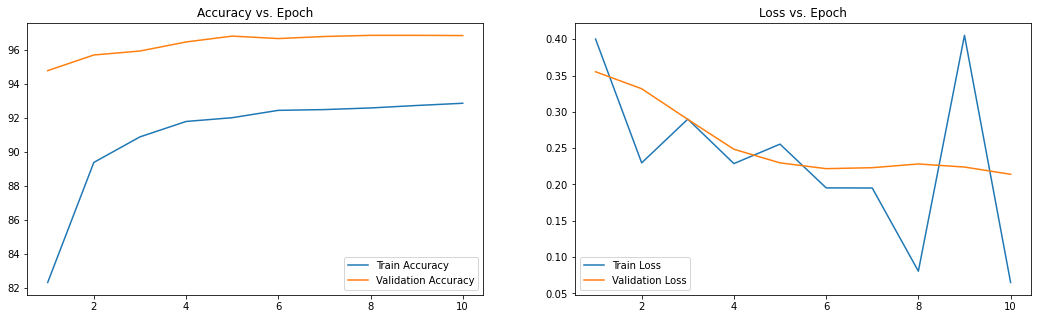

In [92]:
# Plot loss and accuracy curves
fig, (ax1, ax2) = plt.subplots(figsize=(18, 5), ncols=2)
ax1.plot(range(1, epochs + 1), train_acc, label='Train Accuracy')
ax1.plot(range(1, epochs + 1), valid_acc, label='Validation Accuracy')
ax1.legend()
ax1.set_title('Accuracy vs. Epoch')
ax2.plot(range(1, epochs + 1), train_loss, label='Train Loss')
ax2.plot(range(1, epochs + 1), valid_loss, label='Validation Loss')
ax2.legend()
ax2.set_title('Loss vs. Epoch')
plt.show()